<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
<h1> Detector de tapabocas con Machine learning - Aplicamiento de algoritmos de aprendizaje</h1>

Julián Montoya - 201615817

<h1>Contenido<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Imports-necesarios" data-toc-modified-id="1.-Imports-necesarios-1">1. Imports necesarios</a></span></li><li><span><a href="#2.-Leer-imagenes-y--procesarlas" data-toc-modified-id="2.-Leer-imagenes-y--procesarlas-2">2. Leer imagenes y  procesarlas</a></span></li><li><span><a href="#3.-Entrenamiento-de-modelos" data-toc-modified-id="3.-Entrenamiento-de-modelos-3">3. Entrenamiento de modelos</a></span><ul class="toc-item"><li><span><a href="#3.1-CNN-con-entrenamiento-por-transferencia-con-MobileNetV2" data-toc-modified-id="3.1-CNN-con-entrenamiento-por-transferencia-con-MobileNetV2-3.1">3.1 CNN con entrenamiento por transferencia con MobileNetV2</a></span><ul class="toc-item"><li><span><a href="#3.1.3-Compilar-y-entrenar-la-red" data-toc-modified-id="3.1.3-Compilar-y-entrenar-la-red-3.1.1">3.1.3 Compilar y entrenar la red</a></span></li></ul></li></ul></li><li><span><a href="#4.-Predicción" data-toc-modified-id="4.-Predicción-4">4. Predicción</a></span></li><li><span><a href="#5.-Validación" data-toc-modified-id="5.-Validación-5">5. Validación</a></span><ul class="toc-item"><li><span><a href="#5.1-Confussion-matrix" data-toc-modified-id="5.1-Confussion-matrix-5.1">5.1 Confussion matrix</a></span><ul class="toc-item"><li><span><a href="#Confussion-matrix-para-cada-raza" data-toc-modified-id="Confussion-matrix-para-cada-raza-5.1.1">Confussion matrix para cada raza</a></span></li></ul></li><li><span><a href="#5.2-Training-loss-y-accuracy" data-toc-modified-id="5.2-Training-loss-y-accuracy-5.2">5.2 Training loss y accuracy</a></span></li><li><span><a href="#5.3-ROC-AUC" data-toc-modified-id="5.3-ROC-AUC-5.3">5.3 ROC AUC</a></span></li></ul></li></ul></div>

## 1. Imports necesarios

In [2]:
# Tensorflow - keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, roc_curve, auc
from sklearn.pipeline import Pipeline

# files
import argparse
import os
from shutil import copyfile

# Matplotlib, numpy, seaborn
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

## 2. Leer imagenes y  procesarlas

Se leen las imagenes y por medio de las utilidades de preprocesamiento de keras y tensorflow se transforman para poderlas pasar al algoritmo de aprendizaje

In [2]:
# Obtiene las imagenes dado un directorio donde se espera que contenga un folder por clase con las imagenes
# Retorna un array que contiene la data preprocesada de las imágenes y un array con los lables
def loadImages(directory):
    # Arrays para guardar los datos
    data = []
    name = []
    labels = []
    
    # Iterar sobre clases
    files = os.listdir(directory)
    for clase in files:
        
        path = directory + clase + "/"
        for raza in os.listdir(path):
        
            # Iterar sobre las imagenes
            for file in os.listdir(path + raza + '/'):

                # Construir path a la imagen
                pathImg = path + raza + '/' + file

                # Cargar en formato 224 x 224 y preprocesar con keras
                image = load_img(pathImg, target_size=(224, 224))
                image = img_to_array(image)
                image = preprocess_input(image)

                # Añadir a los arrays
                data.append(image)
                labels.append(clase)
                name.append(path + raza + '/' + file)
    
    # Transformar a arrays de numpy y retornar los arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    return data, labels, name

Se obtienen y preprocesan los sets de train, validación y test

In [3]:
X_train, y_train, namesX = loadImages('../Data Processing/Processed_data/Split/Augmented_Train/')

In [4]:
X_val, y_val, namesXVal = loadImages('../Data Processing/Processed_data/Split/Validation/')

In [5]:
X_test, y_test, namestest = loadImages('../Data Processing/Processed_data/Split/Test/')

Pasar los labels a binario

In [6]:
classesId = [('Face_mask_correctly_placed', 0), ('Face_mask_poorly_placed', 1), ('No_face_mask', 2)]
def labelToBinary(y):
    yRet = y
    for i in range(len(y)):
        for j in classesId:
            if y[i]  == j[0]:
                yRet[i] = j[1]
                break
    yRet=yRet.astype('int')
    
    return to_categorical(yRet)

In [7]:
y_train_binary = labelToBinary(y_train) 
y_val_binary = labelToBinary(y_val) 
y_test_binary = labelToBinary(y_test)
y_test_binary

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## 3. Entrenamiento de modelos

### 3.1 CNN con entrenamiento por transferencia con MobileNetV2

Valores para entrenamiento

In [8]:
# Se define un valor para el rate inicial de aprendizaje, el número de epochs y el batch size
learningRateInitial = 1e-4
numEpochs = 10

Se utiliza la red neuronal MobileNetV2 la cuál contiene pesos entrenados 

In [9]:
# Se carga la red sin incluir la cabeza y se congelan sus layers para que no haya entrenamiendo sobre esta parte del modelo
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
for layer in baseModel.layers:
    layer.trainable = False

In [10]:
# Construir cabeza del modelo
headModel = baseModel.output

# Añadimos un average polling de 7*7 para reducir la entrada
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)

# Pasamos la red a plano
headModel = Flatten(name = 'flatten')(headModel)

# Añadimos una capa dense de 256 y activación relu
headModel = Dense(256, activation = 'relu')(headModel)

# Añadir dropout con valor de 0.1
headModel = Dropout(0.1)(headModel)

# Capa output con activacion softmax
headModel = Dense(3, activation = 'softmax')(headModel)

# Poner cabeza en el modelo descargado
modelCNN_1 = Model(inputs=baseModel.input, outputs=headModel)

Se añade un early stopping para buscar menor tiempo de ejecución

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
callbacks = [early_stopping]

#### 3.1.3 Compilar y entrenar la red

In [12]:
# Crear el optimizador, compilar el modelo utilizando categorical_crossentropy
opt = Adam(lr = learningRateInitial, decay = learningRateInitial / 30)
modelCNN_1.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

trainer = modelCNN_1.fit(X_train, y_train_binary,
                    validation_data = (X_val, y_val_binary),
                    epochs = 8,
                    callbacks= callbacks)

Epoch 1/8
671/671 [==============================] - 437s 652ms/step - loss: 0.3378 - accuracy: 0.8650 - val_loss: 0.1920 - val_accuracy: 0.9327
Epoch 2/8
671/671 [==============================] - 436s 650ms/step - loss: 0.2103 - accuracy: 0.9196 - val_loss: 0.1816 - val_accuracy: 0.9358
Epoch 3/8
671/671 [==============================] - 437s 652ms/step - loss: 0.1653 - accuracy: 0.9391 - val_loss: 0.1805 - val_accuracy: 0.9352
Epoch 4/8
671/671 [==============================] - 429s 639ms/step - loss: 0.1343 - accuracy: 0.9521 - val_loss: 0.2111 - val_accuracy: 0.9205
Epoch 5/8
671/671 [==============================] - 433s 645ms/step - loss: 0.1108 - accuracy: 0.9621 - val_loss: 0.1706 - val_accuracy: 0.9405
Epoch 6/8
671/671 [==============================] - 432s 643ms/step - loss: 0.0916 - accuracy: 0.9696 - val_loss: 0.1759 - val_accuracy: 0.9396
Epoch 7/8
671/671 [==============================] - 419s 625ms/step - loss: 0.0776 - accuracy: 0.9759 - val_loss: 0.1629 - val_ac

In [13]:
modelCNN_1.save('Modelo_CNN.h5')

## 4. Predicción

In [18]:
classes = ['Mask_correcly_placed', 'Mask_poorly_placed', 'No_face_mask']

In [16]:
# Predicciones modelo construído
predIdxs = modelCNN_1.predict(X_test)

In [111]:
predsCNN = np.argmax(predIdxs, axis=1)

## 5. Validación

### 5.1 Confussion matrix

In [19]:
print('Reporte para el modelo construido:\n')
print(classification_report(y_test.astype('int'), np.argmax(predIdxs, axis=1), target_names=classes))

Reporte para el modelo construido:

                      precision    recall  f1-score   support

Mask_correcly_placed       0.95      0.97      0.96      1808
  Mask_poorly_placed       0.76      0.71      0.73       212
        No_face_mask       0.99      0.96      0.97      1177

            accuracy                           0.95      3197
           macro avg       0.90      0.88      0.89      3197
        weighted avg       0.95      0.95      0.95      3197



#### Confussion matrix para cada raza

In [23]:
# Obtiene la confussion matriz para la raza dada por parámetro
def printConfussionMatrixForRace(raza):
    print("Confussion matriz de raza " + raza)
    
    # arrays
    preds = np.argmax(predIdxs, axis=1)
    y_test_raza = y_test.copy()
    y_test_binary_raza = y_test_binary.copy()
    
    # ids que no corresponden
    idsRemove = []
    
    # encontrar ids de otras razas
    for i in range(len(y_test_raza)):
        if namestest[i].split("/")[6] != raza :
            idsRemove.append(i)
    
    # eliminar ids que no son de la raza
    y_test_raza = np.delete(y_test_raza, idsRemove)
    preds = np.delete(preds, idsRemove)
    y_test_binary_raza = np.delete(y_test_binary, idsRemove, axis=0)
    
    print(classification_report(y_test_raza.astype('int'), preds, target_names=classes))  
    print("-----------------------------------------------------")
    return preds, y_test_binary_raza, y_test_raza

In [24]:
predsBlack, y_test_binary_black, y_test_black = printConfussionMatrixForRace("Black")
predsWhite, y_test_binary_white, y_test_white = printConfussionMatrixForRace("White")
predsAsian, y_test_binary_asian, y_test_asian = printConfussionMatrixForRace("Asian")

Confussion matriz de raza Black
                      precision    recall  f1-score   support

Mask_correcly_placed       0.87      0.95      0.91       213
  Mask_poorly_placed       0.71      0.75      0.73        32
        No_face_mask       0.99      0.93      0.96       378

            accuracy                           0.93       623
           macro avg       0.86      0.88      0.87       623
        weighted avg       0.94      0.93      0.93       623

-----------------------------------------------------
Confussion matriz de raza White
                      precision    recall  f1-score   support

Mask_correcly_placed       0.96      0.97      0.97       874
  Mask_poorly_placed       0.81      0.79      0.80       122
        No_face_mask       0.99      0.98      0.98       402

            accuracy                           0.96      1398
           macro avg       0.92      0.91      0.92      1398
        weighted avg       0.96      0.96      0.96      1398

--------

In [26]:
def showConfusionMatrix(predictions, y_test_arr, nameSet, nameModel, color):
    # Modelo sin entonación
    print('Resultados modelo ' + nameModel + " para el set " + nameSet)
    plt.figure(figsize=(8,8))
    mat = confusion_matrix(y_test_arr.astype('int'), predictions)
    sns.heatmap(mat.T, square=True, annot=True, cmap=color,fmt='d', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('true label')
    plt.ylabel('predicted label')


Resultados modelo CNN para el set Set test completo


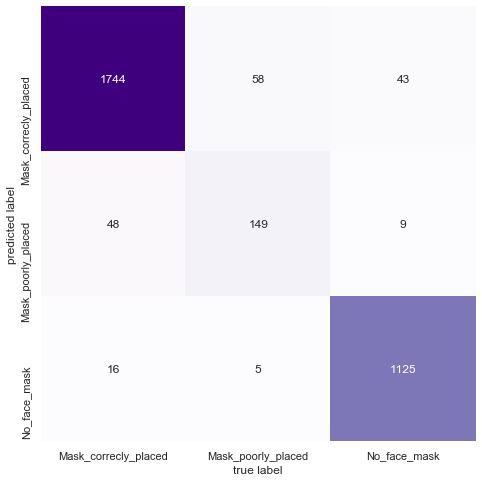

In [114]:
z`

Resultados modelo CNN para el set Set test raza negra


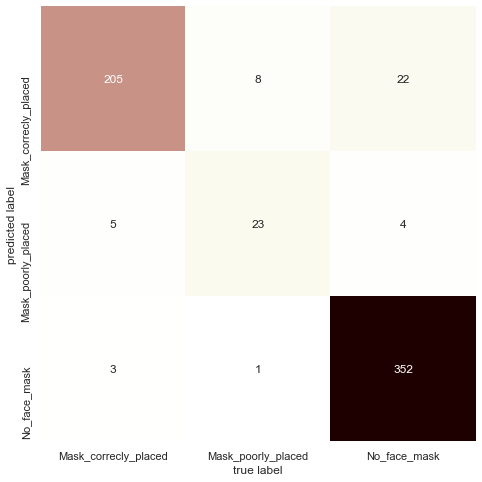

In [124]:
showConfusionMatrix(predsBlack, y_test_black, "Set test raza negra", "CNN", "pink_r")

Resultados modelo CNN para el set Set test raza blanca


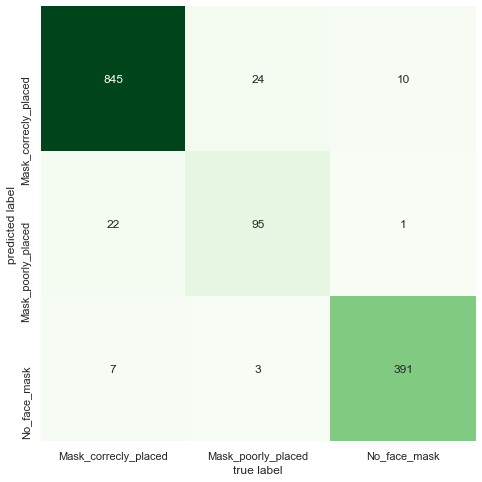

In [119]:
showConfusionMatrix(predsWhite, y_test_white, "Set test raza blanca", "CNN", "Greens")

Resultados modelo CNN para el set Set test raza asiática


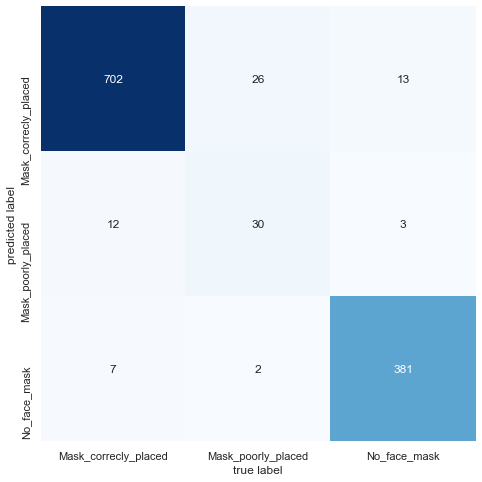

In [27]:
showConfusionMatrix(predsAsian, y_test_asian, "Set test raza asiática", "CNN", "Blues")

### 5.2 Training loss y accuracy

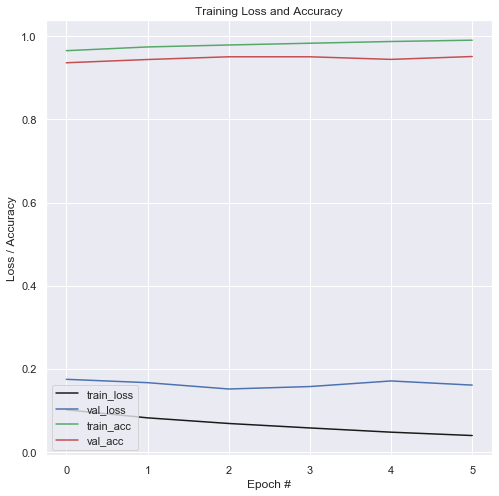

In [21]:
# Plot training loss y accuracy del modelo construído
N = 6
plt.figure(figsize=(8,8))
plt.plot(np.arange(0, N), trainer.history["loss"], label="train_loss", color='k')
plt.plot(np.arange(0, N), trainer.history["val_loss"], label="val_loss", color='b')
plt.plot(np.arange(0, N), trainer.history["accuracy"], label="train_acc", color='g')
plt.plot(np.arange(0, N), trainer.history["val_accuracy"], label="val_acc", color='r')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="lower left")

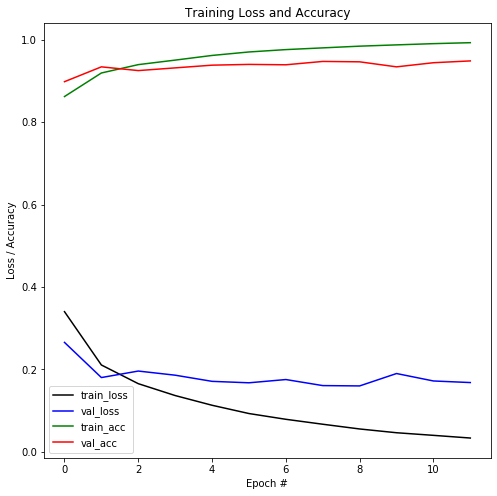

In [19]:
# Plot training loss y accuracy del modelo construído
N = 12
plt.figure(figsize=(8,8))
plt.plot(np.arange(0, N), trainer.history["loss"], label="train_loss", color='k')
plt.plot(np.arange(0, N), trainer.history["val_loss"], label="val_loss", color='b')
plt.plot(np.arange(0, N), trainer.history["accuracy"], label="train_acc", color='g')
plt.plot(np.arange(0, N), trainer.history["val_accuracy"], label="val_acc", color='r')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="lower left")

### 5.3 ROC AUC

Se calculan los resultados promedio de cada AOC de las clases y se grafica.
Código obtenido de: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [101]:
from itertools import cycle
def plotearAverageAOC(predicccions, y_test_binary_arr, nameSet):
    
    print("Ploteando ROC AUC para " + nameSet)
    # Plot linewidth.
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary_arr[:, i], to_categorical(predicccions)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary_arr.ravel(), to_categorical(predicccions).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['green', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.3f})'
                 ''.format(classes[i] , roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curvas ROC promedio por clase')
    plt.legend(loc="lower right")
    plt.show()


Ploteando ROC AUC para Set test completo


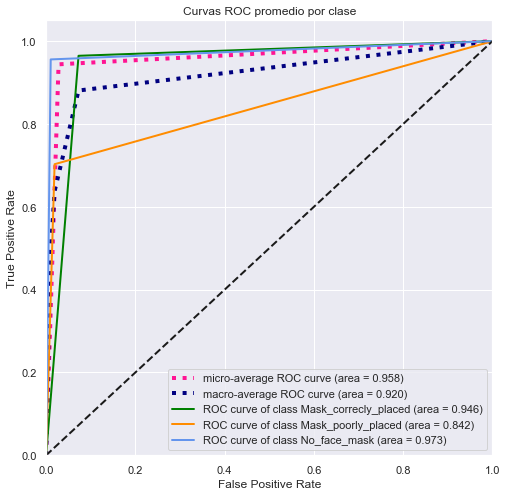

In [102]:
plotearAverageAOC(np.argmax(predIdxs, axis=1), y_test_binary, "Set test completo")

Ploteando ROC AUC para Set test de solo raza negra


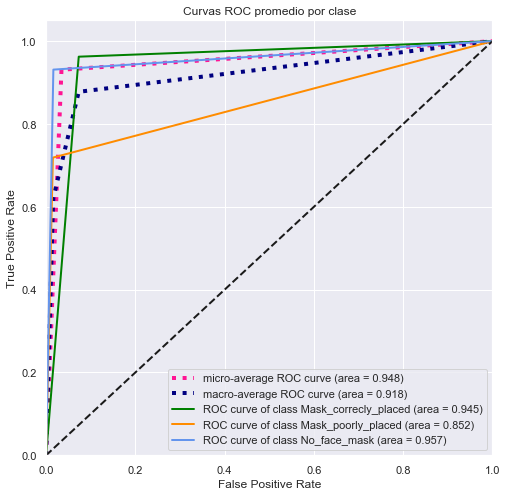

Ploteando ROC AUC para Set test de solo raza blanca


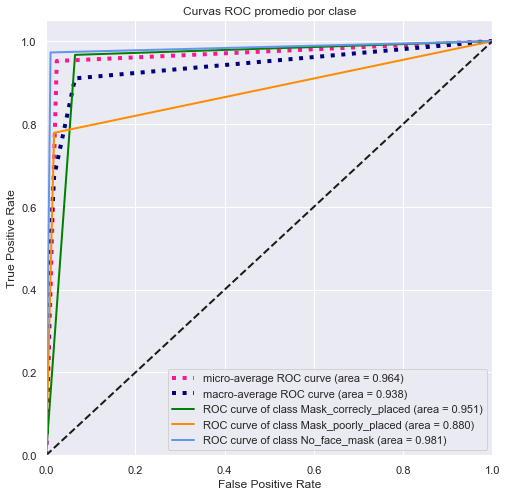

Ploteando ROC AUC para Set test de solo raza asiática


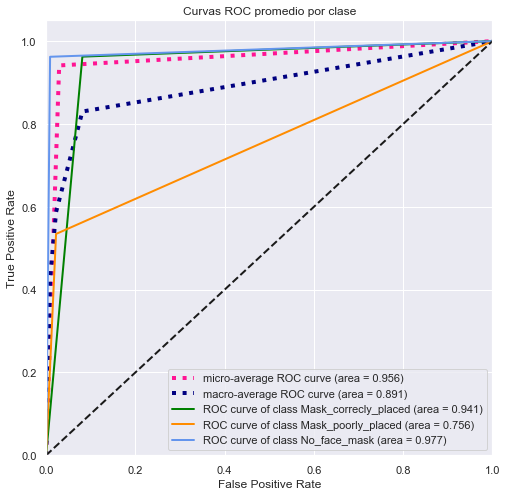

In [106]:
plotearAverageAOC(predsBlack, y_test_binary_black, "Set test de solo raza negra")
plotearAverageAOC(predsWhite, y_test_binary_white, "Set test de solo raza blanca")
plotearAverageAOC(predsAsian, y_test_binary_asian, "Set test de solo raza asiática" )

Video feed

In [3]:
from imutils.video import VideoStream
import time
import imutils
import cv2
from IPython.display import display
from tensorflow.keras.models import load_model
from PIL import Image

In [4]:
pathFaceDetectorModel = '../Data Processing/Models/face_detector'
modelPathCNN1 = 'Modelos/Modelo_CNN1.model'
modelPathCNN2 = 'Modelos/Modelo_CNN.h5'
confidence = 0.5

In [5]:
def detect_and_predict_mask(frame, faceNet, maskNet):
        # grab the dimensions of the frame and then construct a blob
        # from it
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),(104.0, 177.0, 123.0))
        # pass the blob through the network and obtain the face detections
        faceNet.setInput(blob)
        detections = faceNet.forward()
        # initialize our list of faces, their corresponding locations,
        # and the list of predictions from our face mask network
        faces = []
        locs = []
        preds = []
        
        # loop over the detections
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with
            # the detection
            confidence = detections[0, 0, i, 2]
            # filter out weak detections by ensuring the confidence is
            # greater than the minimum confidence
            if confidence > 0.5:
                # compute the (x, y)-coordinates of the bounding box for the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                # ensure the bounding boxes fall within the dimensions of
                # the frame
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
                # extract the face ROI, convert it from BGR to RGB channel
                # ordering, resize it to 224x224, and preprocess it
                face = frame[startY:endY, startX:endX]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)
                # add the face and bounding boxes to their respective
                # lists
                faces.append(face)
                locs.append((startX-20, startY-20, endX+20, endY+20))
                
                # only make a predictions if at least one face was detected
        if len(faces) > 0:
            # for faster inference we'll make batch predictions on *all*
            # faces at the same time rather than one-by-one predictions
            # in the above `for` loop
            faces = np.array(faces, dtype="float32")
            preds = maskNet.predict(faces, batch_size=32)
        # return a 2-tuple of the face locations and their corresponding
        # locations
        return (locs, preds)

In [6]:
def videoStream(modelPath):
    vs = VideoStream(src=0).start()
    time.sleep(2.0)

    # Cargar modelo de deteccion de imagenes
    print("Cargando modelo de reconocimiento facial...")
    prototxtPath = os.path.sep.join([pathFaceDetectorModel, "deploy.prototxt"])
    weightsPath = os.path.sep.join([pathFaceDetectorModel, "res10_300x300_ssd_iter_140000.caffemodel"])
    faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

    # Cargar modelo!
    print("Cargando modelo de detección de uso correcto de tapabocas...")
    maskNet = load_model(modelPath)

    # Inicializar stream
    print("Empezando live feed...")
    vs = VideoStream(src=0).start()
    time.sleep(2.0)

    # loop sobre los frames
    while True:

        # Obtener frame y hacer resize a 400 px
        frame = vs.read()
        frame = imutils.resize(frame, width=400)

        # Obtener predicciones y bounding boxes
        (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

        # Loop sobre las imagenes detectadas
        for (box, pred) in zip(locs, preds):

            # Obtener bounding box y predicciones
            (startX, startY, endX, endY) = box
            (MaskWellPlaced, MaskPoorlyPlaced, NoMask) = pred

            # Determinar la clase
            if MaskWellPlaced > MaskPoorlyPlaced and MaskWellPlaced > NoMask:
                label = 'Mask well placed!'
                color = (0, 255, 0)
            elif MaskPoorlyPlaced > MaskWellPlaced and MaskPoorlyPlaced > NoMask:
                label = 'Mask poorly placed!'
                color = (255,127,80)
            else:
                label = 'No mask!'
                color = (0, 0, 255)
            # Construir string con label y probabilidad
            label = "{}: {:.2f}%".format(label, max(MaskWellPlaced, MaskPoorlyPlaced, NoMask) * 100)

            # Bounding box
            cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

            # Mostrar el output frame
        cv2.imshow("Live face mask detection!", frame)
        key = cv2.waitKey(1) & 0xFF
        # Matar si se oprime la q
        if key == ord("q"):
            break
    # Cerrar y destruir
    cv2.destroyAllWindows()
    vs.stop()

In [7]:
videoStream(modelPathCNN2)

Cargando modelo de reconocimiento facial...
Cargando modelo de detección de uso correcto de tapabocas...
Empezando live feed...


error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
